# Question Answering

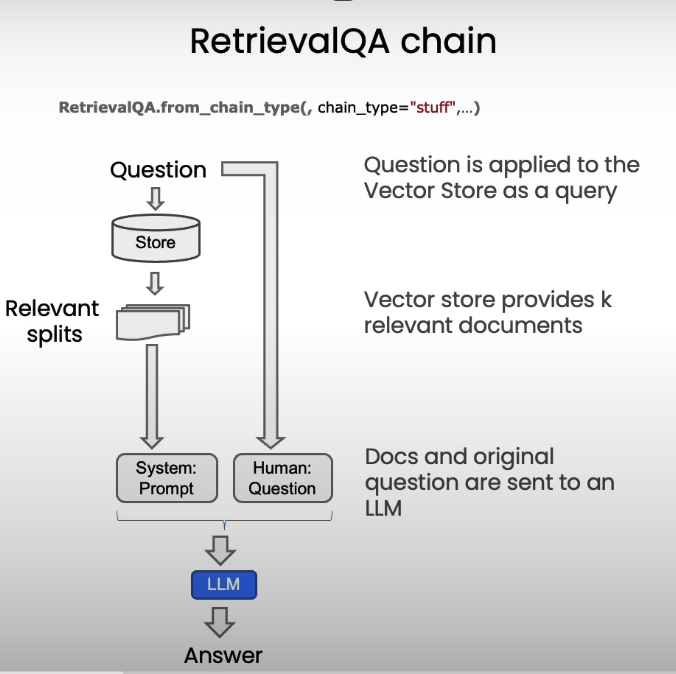

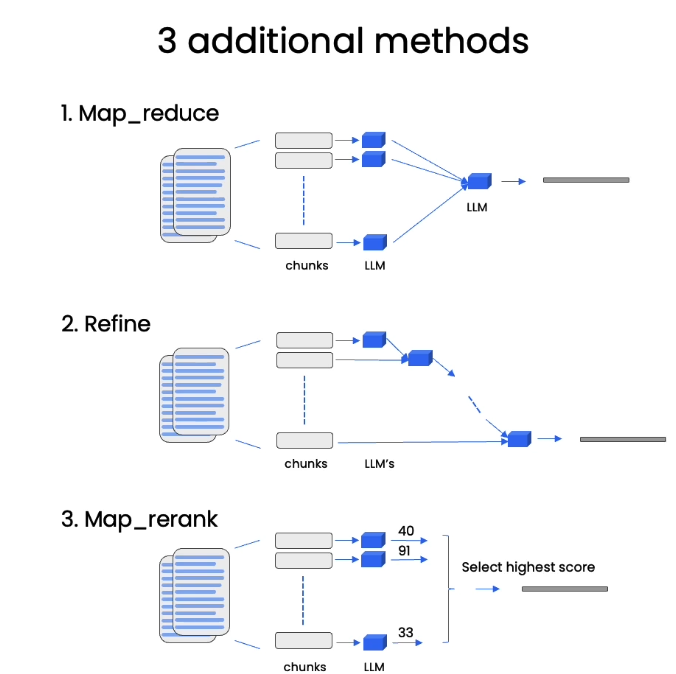

In [1]:
import os
from dotenv import load_dotenv

from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

In [2]:
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")

In [3]:
# Load PDF
loaders = [
    # Duplicate documents on purpose - messy data
    PyPDFLoader("Data/MachineLearning-Lecture01 (Copy).pdf"),
    PyPDFLoader("Data/DeepSeek_R1.pdf"),
    PyPDFLoader("Data/Kolmogorov–Arnold Transformer.pdf"),
    PyPDFLoader("Data/MachineLearning-Lecture01.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

In [5]:
splits = text_splitter.split_documents(docs)

In [6]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
embeddings= HuggingFaceEmbeddings(model_name = model_name)

/tmp/ipykernel_244679/2774317636.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings= HuggingFaceEmbeddings(model_name = model_name)
2025-03-22 20:25:17.032410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742653517.150217  244679 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742653517.181898  244679 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugi

In [7]:
persist_directory = 'docs/chroma/'

In [8]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)

In [9]:
print(vectordb._collection.count())

438


In [10]:
question = "what is agent based modeling"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [11]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [12]:
template = ChatPromptTemplate([
    ("system", "You are a helpful AI assistant that can answer questions about the Machine Learning lectures."),
    ("human", "{user_input}"),
])

In [13]:
llm = ChatGroq(
                api_key=api_key,
                model_name="deepseek-r1-distill-qwen-32b",
                temperature=0.2,  # Lower temperature for more consistent responses
                max_tokens=2048    # Ensure sufficient tokens for detailed answers
            )
output_parser = StrOutputParser()
chain = template|llm|output_parser

### RetrievalQA chain

In [14]:
from langchain.chains import RetrievalQA

In [15]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [16]:
result = qa_chain({"query": question})
print(result["result"])

/tmp/ipykernel_244679/3585339807.py:1: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": question})


<think>
Okay, so I need to figure out what agent-based modeling is. I remember hearing the term before, but I'm not exactly sure what it entails. Let me start by breaking down the components: "agent" and "modeling." 

An agent, in this context, is probably an entity that makes decisions or performs actions within a system. Modeling refers to creating a representation or simulation of a real-world process. So, putting them together, agent-based modeling (ABM) likely involves simulating systems where multiple agents interact.

I think ABM is used in various fields like economics, biology, and social sciences. For example, in traffic flow, each car could be an agent making decisions based on its surroundings. In epidemiology, agents might represent individuals who can spread a disease.

I recall that ABMs are different from traditional models because they focus on the interactions between agents rather than on aggregated data. This means that the behavior of the system emerges from the in

In [17]:
from langchain.prompts import PromptTemplate

In [18]:
# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [19]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [20]:
question = "Difference between supervised and unsupervised learning"
result = qa_chain({"query": question})
print(result["result"])

<think>
Okay, so I need to figure out the difference between supervised and unsupervised learning. Let me start by recalling what I know about machine learning. I remember that there are different types of learning algorithms, and supervised and unsupervised are two of them. 

From the context provided, the teacher is explaining these concepts. In supervised learning, it seems like the data has the correct answers or labels. For example, in the example given, patients are labeled as having malignant or benign tumors. The algorithm's job is to learn from this labeled data and then predict the correct labels for new data. So, it's like having a teacher who provides the right answers, and the model learns to replicate that.

On the other hand, unsupervised learning doesn't have these labels. The data is just given without any correct answers. The goal here is for the algorithm to find patterns or structures on its own. The teacher mentioned that the model is asked to find interesting stru

In [21]:
result["source_documents"][0]

Document(metadata={'page': 15, 'source': 'Data/MachineLearning-Lecture01.pdf'}, page_content='classes teach. And this is something I\'m really convinced is a huge deal, and so by the \nend of this class, I hope all of you will be master carpenters. I hope all of you will be \nreally good at applying these learning algorithms and getting them to work amazingly \nwell in many problems. Okay?  \nLet\'s see. So [inaudible] the board. After learning theory, there\'s another class of learning \nalgorithms that I then want to teach you about, and that\'s unsupervised learning. So you \nrecall, right, a little earlier I drew an example like this, right, where you have a couple of \nfeatures, a couple of input variables and sort of malignant tumors and benign tumors or \nwhatever. And that was an example of a supervised learning problem because the data \nyou have gives you the right answer for each of your patients. The data tells you this \npatient has a malignant tumor; this patient has a be

### RetrievalQA chain types

In [22]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [23]:
# question = "Difference between supervised and unsupervised learning"
# result = qa_chain_mr({"query": question})
# print(result["result"])

# Chat

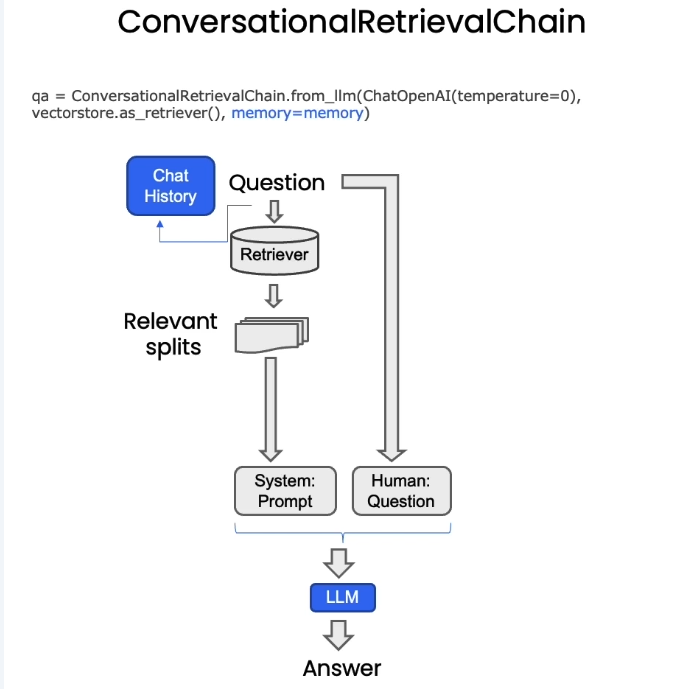

### Memory

In [24]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

/tmp/ipykernel_244679/1956280058.py:2: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


### ConversationalRetrievalChain

In [25]:
from langchain.chains import ConversationalRetrievalChain
retriever=vectordb.as_retriever()
qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)

In [27]:
question = "Is probability a class topic?"
result = qa({"question": question})

In [30]:
print(result['answer'])

<think>
Alright, so I need to figure out how to rephrase the question "Is probability a class topic?" into a standalone question without relying on the previous context. The original conversation was about the Kolmogorov-Arnold Transformer (KAT), which relates to probability through the Kolmogorov-Arnold theorem. 

The user's follow-up question seems to be asking if probability is a topic covered in the class where KAT is taught. To make this a standalone question, I should clarify that it's about whether probability is a topic in the class related to KAT.

I think the best way to phrase it is to directly link probability to the class topic of KAT. So, the rephrased question would be: "Is probability a class topic related to the Kolmogorov-Arnold Transformer?" This makes it clear and concise without assuming prior context.
</think>

Is probability a class topic related to the Kolmogorov-Arnold Transformer?


## Thats about the Learning